## Modules

In [2]:
import os
from tqdm import tqdm

from PIL import Image
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, correlate, butter, freqs, filtfilt
from scipy.ndimage import gaussian_filter, median_filter, shift
from scipy.stats import sem
from scipy.optimize import curve_fit

import tifffile as tff
import seaborn as sns
import seaborn_image as isns
import cmcrameri.cm as cmc
from matplotlib import pyplot as plt
from skimage.registration import phase_cross_correlation
# import ants
import csv

# cmap = 'cmc.batlow'
# sns.set_palette(cmap)

## Analysis Functions

### Generate ioi matrix

In [32]:
def ioi_path_length_factor(lambda1, lambda2, npoints):
    """
    Return the pathlength values in cm from Ma. et al., Phil. Trans. R. Soc. B 371: 20150360.
    Values are stored in the 'Ma_values.txt' file.
    Parameters
    ----------
    lambda1/lambda2: scalar
        Wavelengths between which to return pathlength values
    npoints: int
        Number of sampling points between lambda1/2.
    Returns
    -------
    pathlengths: 1darray
        Pathlength values in mm between lambda1 and lambda2
    """
    with open(r"C:\Users\gabri\Documents\Université\Maitrise\Projet\Widefield-Imaging-Acquisition\analysisPipeline\Ma_values.txt", 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=' ')
        ma_values = []
        for row in reader:
            ma_values.append(list(map(float, row)))
    z = np.array(ma_values) #col1: wavelengths, col2: z in mm
    z[:,1] = z[:,1]/10 #Convert to cm
    if z[0,0] > lambda1:
        z = np.concatenate((np.array([[lambda1, 0], [z[0, 0]*0.9999, 0]]), z), axis=0)
    if z[-1,0] < lambda2:
        z = np.concatenate((z, np.array([[z[-1, 0]*1.00001, 0], [lambda2, 0]])), axis=0)
    xi = np.linspace(lambda1, lambda2, npoints)
    x = z[:, 0]
    pathlengths = z[:, 1]
    pathlengths = np.interp(xi, x, pathlengths)
    return pathlengths


def ioi_get_extinctions(lambda1, lambda2, npoints):
    """
    Returns the extinction coefficients (epsilon) for Hbo and HbR as a function of wavelength between lambda1 and lambda2
    Values in 1/(cm*M) by Scott Prahl at http://omlc.ogi.edu/spectra/hemoglobin/index.html are stored in the Prahl_values.txt file.
    Parameters
    ----------
    lambda1/lambda2: scalar
        Wavelengths between which to return extinction values
    npoints: int
        Number of sampling points between lambda1/2.
    Returns
    -------
    ext_HbO/HbR: 1darrays
        Extinction values for HbO and HbR in 1/(cm*M) between lambda1 and lambda2
    """
    with open(r"C:\Users\gabri\Documents\Université\Maitrise\Projet\Widefield-Imaging-Acquisition\analysisPipeline\Prahl_values.txt", 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=' ')
        prahl_values = []
        for row in reader:
            prahl_values.append(list(map(float, row)))
    E = np.array(prahl_values)
    E[:,1:3] = E[:,1:3]*2.303 #correction for neperian form of the B-L law
    xi = np.linspace(lambda1, lambda2, npoints)
    x = E[:,0]
    y_HbO = E[:,1]
    y_HbR = E[:,2]
    ext_HbO = np.interp(xi, x, y_HbO)
    ext_HbR = np.interp(xi, x, y_HbR)
    return ext_HbO, ext_HbR


def ioi_epsilon_pathlength(lambda1, lambda2, npoints, baseline_hbt, baseline_hbo, baseline_hbr, filter):
    """
    Returns the extinction coefficient*pathlength curve for Hbo and HbR as a function of wavelength between lambda1 and lambda2
    Parameters
    ---------
    lambda1/2: scalars
        Wavelengths between which the system specs are defined.
    npoints: int
        Number of wavelength sampling points in system specs
    baseline_hbt/o/r: scalars
        Baseline concentrations of HbT, HbO and HbR in the brain, in uM
    filter: boolean
        Specify if the fluoresence emission filter was in place.
    Returns
    -------
    eps_pathlength: 2darray
        2d matrix of the epsilon*pathlength values for both imaging wavelengths (rows) and chromophores (columns) in 1/M.
        This matrix is used to solve the modified Beer-Lambert equation for HbO and HbR concentration changes.
    """
    os.chdir(r"C:\Users\gabri\Documents\Université\Maitrise\Projet\Widefield-Imaging-Acquisition")
    wl = np.linspace(lambda1, lambda2, npoints)
    # c_camera
    QE_moment = np.loadtxt(r"analysisPipeline\specs sys optique\QE_moment_5px.csv", delimiter=';')
    p = np.poly1d(np.polyfit(QE_moment[:,0], QE_moment[:,1], 10))
    c_camera = p(wl)/np.max(p(wl))
    QE_moment, p = None, None
    # c_led
    FBH530 = np.loadtxt(r"analysisPipeline\specs sys optique\FBH530-10.csv", skiprows=1, usecols=(0, 2), delimiter=';')
    f = interp1d(FBH530[:,0], FBH530[:,1])
    c_FBH530 = f(wl)/np.max(f(wl))
    FBH630 = np.loadtxt(r"analysisPipeline\specs sys optique\FBH630-10.csv", skiprows=1, usecols=(0, 2), delimiter=';')
    f = interp1d(FBH630[:,0], FBH630[:,1])
    c_FBH630 = f(wl)/np.max(f(wl))
    c_led = np.array([c_FBH530, c_FBH630])
    FBH530, FBH630, c_FBH530, c_FBH630, f = None, None, None, None, None 
    c_tot = baseline_hbt*10**-6  # Rough baseline concentrations in M
    c_pathlength = ioi_path_length_factor(lambda1, lambda2, npoints)
    c_ext_hbo, c_ext_hbr = ioi_get_extinctions(lambda1, lambda2, npoints)
    # Create vectors of values for the fits
    CHbO = baseline_hbo/baseline_hbt*c_tot*np.linspace(0, 1.5, 16) #in M
    CHbR = baseline_hbr/baseline_hbt*c_tot*np.linspace(0, 1.5, 16)
    # In this computation we neglect the fact that pathlength changes with total concentration
    # (it is fixed for a Ctot of 100e-6)
    eps_pathlength = np.zeros((2, 2))
    IHbO = np.zeros(np.shape(CHbO))
    IHbR = np.zeros(np.shape(CHbR))
    for iled in range(2):
        for iconc in range(len(CHbO)):
            IHbO[iconc] = np.sum(c_camera*c_led[iled]*np.exp(-c_ext_hbo*c_pathlength*CHbO[iconc]))
            IHbR[iconc] = np.sum(c_camera*c_led[iled]*np.exp(-c_ext_hbr*c_pathlength*CHbR[iconc]))
        IHbO = IHbO/np.max(IHbO)
        IHbR = IHbR/np.max(IHbR)
        # Compute effective eps
        # plt.plot(c_camera*c_led[iled]*np.exp(-c_ext_hbr*c_pathlength*CHbO[iconc]), 'r.')
        # plt.plot(c_camera*c_led[iled]*np.exp(-c_ext_hbo*c_pathlength*CHbR[iconc]), 'g.')
        p1 = np.polyfit(CHbO, -np.log(IHbO), 1)
        p2 = np.polyfit(CHbR, -np.log(IHbR), 1)
        HbOL = p1[0]
        HbRL = p2[0]
        eps_pathlength[iled, 0] = HbOL
        eps_pathlength[iled, 1] = HbRL
    # print(eps_pathlength)
    return eps_pathlength

### 2D analysis (time series)

In [14]:
def lowpass_filter2D(sig:list, cutoff:float=1, fs:float=10, order:int=5)->list:
    """lowpass filter easy to use for data

    Args:
        sig (list): 1D array of data (timeseries, flattenned frames)
        cutoff (float): cutoff frequency.  Defaults to 1
        fs (float, optional): sampling frequency. Defaults to 10.
        order (int, optional): order of the butter filter. Defaults to 5.

    Returns:
        list: filtered data
    """
    nyq = 0.5 * fs
    low = cutoff / nyq
    b, a = butter(order, low, btype='low')
    filtered_data = filtfilt(b, a, sig, axis=0)
    return filtered_data
    

def regress_drift2D(sig:list, time:list)-> list:
    """Prepares raw data to calculate HbO and HbR: removes 
        drift if any, and normalizes around 1

    Args:
        sig (list): 1D array containing signal
        time (list): 1D array containing time
        
    Returns:
        list: returns only the signal in a 1D array. Time is the same.
    """
    def droite(x, a, b):
        return a*x + b
    
    popt, pcov = curve_fit(droite, time, sig)
    pcov = None
    sig_r = sig/droite(time, *popt)

    return sig_r

In [18]:
def prepToCompute2D(sig:list, time:list, filter=False, cutoff:float=1, regress=True):
    """_summary_

    Args:
        sig (list): 1D array of signal (timeseries)
        time (list): 1D array of time associated with sig. Must be same length
        filter (bool, optional): lowpass filter. Defaults to False.
        cutoff (float, optional): cutoff frequency for lowpass filter. Defaults to 1.
        regress (bool, optional): linear regression for LED drift. Centers data around 1. Defaults to True.

    Returns:
        _type_: 1D array of sig
    """
    if filter:
        print("Filtering data")
        # sig = lowpass_filter2D(sig, cutoff)
        sig = gaussian_filter(sig, sigma=1)

    if regress:
        print("Regressing data")
        sig = regress_drift2D(sig, time)

    return sig

def convertToHb2D(data_green, data_red):
    """converts green and red signals to Hb variation in tissue

    Args:
        data_green (list): preprocessed green timeseries
        data_red (list): preprocessed red timeseries

    Returns:
        list: 2D array (d_HbO, d_HbR) 
    """
    lambda1 = 450 #nm
    lamba2 = 700 #nm
    npoints = 1000
    baseline_hbt = 100 #uM
    baseline_hbo = 60 #uM
    baseline_hbr = 40 #uM
    rescaling_factor = 1e6
    
    eps_pathlength = ioi_epsilon_pathlength(lambda1, lamba2, npoints, baseline_hbt, baseline_hbo, baseline_hbr, filter=None)
    Ainv = np.linalg.pinv(eps_pathlength)*rescaling_factor
    ln_green = -np.log(data_green.flatten())
    ln_red = -np.log(data_red.flatten())
    ln_R = np.concatenate((ln_green.reshape(1,len(ln_green)),ln_red.reshape(1,len(ln_green))))
    Hbs = np.matmul(Ainv, ln_R)
    d_HbO = Hbs[0].reshape(np.shape(data_green))
    d_HbR = Hbs[1].reshape(np.shape(data_green))
    # Protection against aberrant data points
    np.nan_to_num(d_HbO, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    np.nan_to_num(d_HbR, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    
    return d_HbO, d_HbR


def dHb_pipeline2D(data_path, save_path, filter=False, cutoff=2, regress=True):
    """pipeline to compute Hb from raw data. Data must the sorted first, see data_path arg.

    Args:
        data_path (string): path of the raw data. Data must be sorted first with the 'splitChannels.py' script, 
        and timestamps extracted with 'extract_ts_moment.py'
        save_path (string): path of folder where computed data must be saved
        filter (bool, optional): lowpass time filter. Defaults to False.
        cutoff (float, optional): cutoff frequency if filter used. Defaults to 0.2.
        regress (bool, optional): linear regression to remove LED drift and center data around 1. Defaults to True.
    """
    # process green
    green = np.loadtxt(data_path + "\\csv\\530.csv", skiprows=1, delimiter=',')[:,1]
    green_t = np.load(data_path + "\\530ts.npy")
    print("Green data loaded")
    green = prepToCompute2D(green, green_t, filter, cutoff, regress)
    np.save(data_path + "\\530preped.npy", green)
    green = None
    print("Green data saved")

    # process red    
    red = np.loadtxt(data_path + "\\csv\\625.csv", skiprows=1, delimiter=',')[:,1]
    red_t = np.load(data_path + "\\625ts.npy")
    print("Red data loaded")
    red = prepToCompute2D(red, red_t, filter, cutoff, regress)
    np.save(data_path + "\\625preped.npy", red)
    red = None
    print("Red data saved")

    # convert to hb
    print("Convert to dHb")
    green = np.load(data_path + "\\530preped.npy")
    red = np.load(data_path + "\\625preped.npy")
    d_HbO, d_HbR = convertToHb2D(green, red)
    Hb = np.array((d_HbO, d_HbR, d_HbO+d_HbR))

    # save processed data
    np.save(save_path + "\\computedHb.npy", Hb)
    print("Done")

test = False
if test:
    data_path = r"C:\Users\gabri\Desktop\testAnalyse\2024_07_18"
    save_path = data_path
    dHb_pipeline2D(data_path, save_path, filter=True, regress=True)

### 3D analysis (frames)

In [9]:
def identify_files(path, keywords):
    items = os.listdir(path)
    files = []
    for item in items:
        if all(keyword in item for keyword in keywords):
            files.append(item)
    files = [os.path.join(path, f) for f in files]
    files.sort(key=lambda x: os.path.getmtime(x))
    return files


def resample_pixel_value(data, bits):
    plage = 2**bits - 1
    return (plage * (data - np.min(data))/(np.max(data - np.min(data))))


def save_as_tiff(frames, prefixe, save_path):
    """_summary_

    Args:
        frames (array): 3D array of one type of data, ex HbO, HbR, or HbT
        prefixe (str): type of data
        save_path (str): folder to save data
    """
    for idx, frame in tqdm(enumerate(frames)):
        im = Image.fromarray(frame, mode='I;16')
        im.save(save_path + "\\{}.tiff".format(prefixe + str(idx)), "TIFF")


def create_npy_stack(folder_path:str, save_path:str,  wl:int, saving=False):
    """creates a 3D npy stack of raw tiff images

    Args:
        folder_path (str): folder containing tiff frames
        save_path (str): folder to save npy stack
        wl (int): wavelength for saved file name
    """
    files = identify_files(folder_path, "tif")
    # files=files[:250]
    for idx, file in tqdm(enumerate(files)):
        # frame = tff.TiffFile(folder_path+"\\"+file).asarray()
        frame = tff.TiffFile(file).asarray()
        if idx == 0:
            num_frames = len(files)
            frame_shape = frame.shape
            stack_shape = (num_frames, frame_shape[0], frame_shape[1])
            _3d_stack = np.zeros(stack_shape, dtype=np.uint16)
        _3d_stack[idx,:,:] = frame

    if saving:
        np.save(save_path+"\\{}_rawStack.npy".format(wl), _3d_stack)
    return _3d_stack


def motion_correction(frames):
    """Applies motion correction based on a phase cross correlation

    Args:
        frames (_type_): 3D array of frames before correction

    Returns:
        _type_: 3D array of frames after correction
    """
    fixed_frame = frames[0,:,:]
    motion_corrected = np.zeros((frames.shape), dtype=np.uint16)
    for idx, frame in tqdm(enumerate(frames)):
        if idx == 0:
            motion_corrected[0,:,:] = frame
            continue
        shifted, error, diffphase = phase_cross_correlation(fixed_frame, frame, upsample_factor=10)
        corrected_image = shift(frame, shift=(shifted[0], shifted[1]), mode='reflect')
        motion_corrected[idx,:,:] = corrected_image
    
    shifted, error, diffphase, corrected_image, fixed_frame = None, None, None, None, None
    return motion_corrected


def bin_pixels(frames, bin_size=2):
    """Bins pixels with bin size

    Args:
        frames (array): 3D array of frames. 
        bin_size (int, optional): size of pixel bins. Defaults to 2.

    Returns:
        array: 3D array, stack of binned data
    """
    for idx, frame in tqdm(enumerate(frames)):
        if idx == 0:
            height, width = frame.shape[:2]
            binned_height = height // bin_size
            binned_width = width // bin_size
            binned_frames = np.zeros((len(frames), binned_height, binned_width), dtype=np.uint16)

        reshaped_frame = frame[:binned_height * bin_size, :binned_width * bin_size].reshape(binned_height, bin_size, binned_width, bin_size)

        binned_frame = np.sum(reshaped_frame, axis=(1, 3), dtype=np.float32)
        binned_frame = binned_frame / (bin_size**2)
        binned_frames[idx,:,:] = binned_frame

    height, width, binned_height, binned_width, reshaped_frame = None, None, None, None, None
    return binned_frames



def lowpass_filter(sig:list, cutoff:float=1, fs:float=10, order:int=5)->list:
    """lowpass filter easy to use for data

    Args:
        sig (list): 1D array of data (timeseries, flattenned frames)
        cutoff (float): cutoff frequency.  Defaults to 1
        fs (float, optional): sampling frequency. Defaults to 10.
        order (int, optional): order of the butter filter. Defaults to 5.

    Returns:
        list: filtered data
    """
    nyq = 0.5 * fs
    low = cutoff / nyq
    b, a = butter(order, low, btype='low')
    filtered_data = filtfilt(b, a, sig, axis=0)
    return filtered_data


def regress_drift(sig:list, time:list, save_path, wl:int=530)-> list:
    """Prepares raw data to calculate HbO and HbR: removes 
        drift if any, and normalizes around 1

    Args:
        sig (list): 1D array containing signal
        time (list): 1D array containing time
        wl (int): wavelength of light corresponding to data, necessary for saving data as npy. Defaults to 530
        filter (bool): activate Defaults to False
        
    Returns:
        list: returns only the signal in a 1D array. Time is the same.
    """
    def droite(x, a, b):
        return a*x + b
    
    print("Global regression")
    popt, pcov = curve_fit(droite, time, sig)
    pcov = None
    sig_r = sig/droite(time, *popt)

    return sig_r


In [51]:
def prepToCompute(frames:list, correct_motion=False, bin_size=None, regress=False):
    """_summary_

    Args:
        frames (list): _description_
        correct_motion (bool, optional): _description_. Defaults to False.
        filter (bool, optional): _description_. Defaults to False.
        bin_size (_type_, optional): _description_. Defaults to None.
        regress (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: _description_
    """
    if correct_motion:
        print("Correcting motion")
        frames = motion_correction(frames)
    if bin_size is not None:
        print("Bining pixels")
        frames = bin_pixels(frames, bin_size=bin_size)
    if regress:
        print("Normalizing")
        frames = frames/np.mean(frames, axis=0)
    
    return frames

def convertToHb(data_green, data_red):
    """_summary_

    Args:
        data_green (_type_): _description_
        data_red (_type_): _description_

    Returns:
        _type_: _description_
    """
    lambda1 = 450 #nm
    lamba2 = 700 #nm
    npoints = 1000
    baseline_hbt = 100 #uM
    baseline_hbo = 60 #uM
    baseline_hbr = 40 #uM
    rescaling_factor = 1e6
    
    eps_pathlength = ioi_epsilon_pathlength(lambda1, lamba2, npoints, baseline_hbt, baseline_hbo, baseline_hbr, filter=None)
    Ainv = (np.linalg.pinv(eps_pathlength)*rescaling_factor).astype(np.float32)
    ln_green = -np.log(data_green.flatten())
    ln_red = -np.log(data_red.flatten())
    ln_R = np.concatenate((ln_green.reshape(1,len(ln_green)),ln_red.reshape(1,len(ln_green))))
    Hbs = np.matmul(Ainv, ln_R).astype(np.float32)
    d_HbO = Hbs[0].reshape(np.shape(data_green))
    d_HbR = Hbs[1].reshape(np.shape(data_green))
    # Protection against aberrant data points
    np.nan_to_num(d_HbO, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    np.nan_to_num(d_HbR, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    
    return d_HbO, d_HbR


def dHb_pipeline(data_path, save_path, correct_motion=True, bin_size=3, filter=False, regress=True):
    """_summary_

    Args:
        data_path (_type_): _description_
        save_path (_type_): _description_
        correct_motion (bool, optional): _description_. Defaults to True.
        bin_size (int, optional): _description_. Defaults to 3.
        filter (bool, optional): _description_. Defaults to True.
        cutoff (float, optional): _description_. Defaults to 0.2.
        regress (bool, optional): _description_. Defaults to True.
    """
    # process green
    print("Loading green data")
    green = create_npy_stack(data_path + "\\530", data_path, 530, saving=False)
    # green = np.load(data_path + "\\530_rawStack.npy")
    print("Green data loaded")
    green = prepToCompute(green, wl=530, correct_motion=correct_motion, bin_size=bin_size, regress=regress)
    green = np.save(data_path + "\\530preped.npy", green)
    green = None
    print("Green data preped and saved")

    # process red
    print("Loading red data")
    red = create_npy_stack(data_path + "\\625", data_path, 625, saving=False)
    # red = np.load(data_path + "\\625_rawStack.npy")
    print("Red data loaded")
    red = prepToCompute(red, wl=625, correct_motion=correct_motion, bin_size=bin_size, regress=regress)
    red = np.save(data_path + "\\625preped.npy", red)
    red = None
    print("Red data preped and saved")

    # convert to hb
    print("Converting to dHb")
    green = np.load(data_path + "\\530preped.npy")
    red = np.load(data_path + "\\625preped.npy")
    d_HbO, d_HbR = convertToHb(green, red)
    d_HbT = d_HbO+d_HbR
    # resample pixel values
    d_HbO = resample_pixel_value(d_HbO, 16).astype(np.uint16)
    d_HbR = resample_pixel_value(d_HbR, 16).astype(np.uint16)
    d_HbT = resample_pixel_value(d_HbT, 16).astype(np.uint16)
    Hb = np.array((d_HbO, d_HbR, d_HbT))
    # filter if needed
    if filter:
        print("Filtering")
        Hb = gaussian_filter(Hb, sigma=1, axes=(2, 3))
    # save processed data as npy
    np.save(save_path + "\\computedHb.npy", Hb)
    # save as tiff
    print("Saving processed Hb")
    data_types = ['HbO', 'HbR', 'HbT']
    for frames, typpe in zip(Hb, data_types):
        try:
            os.mkdir(save_path + "\\"  + typpe)
        except FileExistsError:
            print("Folder already created")
        save_as_tiff(frames, typpe, save_path + "\\" + typpe)

    print("Done")

## Tests

In [19]:
test = False
if test:
    data_path = r"Z:\gGermain\2024_09_12\4"
    save_path = data_path
    dHb_pipeline(data_path, save_path, filter=False, bin_size=None)


# tests gaussian filter
%matplotlib inline
# %matplotlib qt
# data = np.load(r"Z:\gGermain\2024_09_12\4\computedHb_nofilter.npy")
# data_filtered = gaussian_filter(data, sigma=2.5, axes=(1))
# # frame = 117
# # plt.imshow(data[0,frame])
# # plt.show()
# # plt.imshow(data_filtered[0,frame])
# # plt.show()

# data_types = ['HbO', 'HbR', 'HbT']
# save_path = r"Z:\gGermain\2024_09_12\4"
# for frames, typpe in zip(data_filtered, data_types):
#     try:
#         os.mkdir(save_path + "\\"  + typpe)
#     except FileExistsError:
#         print("Folder already created")
#     save_as_tiff(frames, typpe, save_path + "\\" + typpe)




## Correlation avec HbO HbR

In [34]:
# correlation = correlate(AP_series, HbO*-1+2e-5)
# lag = np.argmax(correlation)
# print('lag:', (len(red_t) - lag)*1/10, 's')
# plt.plot(correlation)
# correlation = correlate(AP_series, HbR*-1+2e-5)
# lag = np.argmax(correlation)
# print('lag:', (len(red_t) - lag)*1/10, 's')
# plt.plot(correlation)

## Cutting frames around air puffs

In [20]:
AP_times = np.array([  12.01,   35.2 ,   46.51,   74.12,   91.14,  103.63,  114.48,
        132.14,  142.77,  169.61,  182.33,  197.83,  209.56,  223.5 ,
        239.35,  252.31,  263.77,  279.97,  297.53,  310.62,  323.38,
        335.92,  365.67,  383.93,  402.83,  417.51,  430.48,  440.9 ,
        456.7 ,  468.25,  480.64])

green_t = np.load(r"Z:\gGermain\2014_09_17\3\530ts.npy")
red_t = np.load(r"Z:\gGermain\2014_09_17\3\625ts.npy")

AP_idx_g = []
AP_idx_r = []
for ti in AP_times:
    AP_idx_g.append(np.argmin(np.absolute(green_t-ti)))
    AP_idx_r.append(np.argmin(np.absolute(red_t-ti)))

print(AP_idx_r)
print(AP_idx_g)

N_AP = np.min([len(AP_idx_g), len(AP_idx_r)]) - 1
print(N_AP)

Nf_bef = 3*10
Nf_aft = 10*10
N_tot = Nf_bef + Nf_aft

green_files = identify_files(r"Z:\gGermain\2014_09_17\3\530", "tif")
red_files = identify_files(r"Z:\gGermain\2014_09_17\3\625", "tif")




[121, 353, 467, 744, 915, 1040, 1149, 1326, 1433, 1703, 1830, 1986, 2103, 2243, 2403, 2533, 2648, 2810, 2987, 3118, 3246, 3372, 3671, 3854, 4044, 4191, 4321, 4426, 4584, 4700, 4825]
[121, 353, 467, 744, 915, 1040, 1149, 1326, 1433, 1703, 1830, 1986, 2103, 2243, 2403, 2533, 2648, 2810, 2987, 3118, 3246, 3372, 3671, 3854, 4044, 4191, 4321, 4426, 4584, 4700, 4825]
30


100%|██████████| 130/130 [03:13<00:00,  1.49s/it]


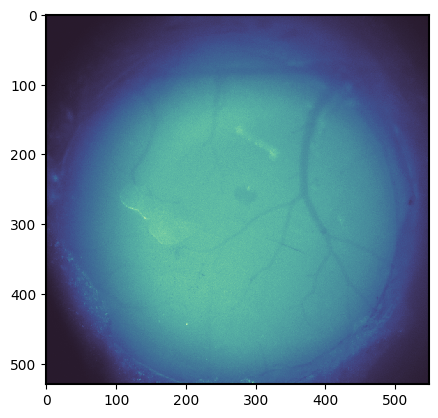

In [21]:
frame_shape = tff.TiffFile(green_files[0]).asarray().shape
avg_ts_g = np.zeros((N_tot, frame_shape[0], frame_shape[1]))   # average rx over time
avg_ts_r = np.zeros((N_tot, frame_shape[0], frame_shape[1]))   # average rx over time


for moment in tqdm(range(N_tot)):
    avg_frame_g = np.zeros((N_AP, frame_shape[0], frame_shape[1]))      # average rx for on moment over all AP
    avg_frame_r = np.zeros((N_AP, frame_shape[0], frame_shape[1]))      # average rx for on moment over all AP
    for APn in range(N_AP):
        idx = AP_idx_g[APn] - Nf_bef + moment
        #green
        file = green_files[idx]
        avg_frame_g[APn] = tff.TiffFile(file).asarray()
        #red 
        file = red_files[idx]
        
        avg_frame_r[APn] = tff.TiffFile(file).asarray()

    avg_ts_g[moment] = np.mean(avg_frame_g, axis=0)
    avg_ts_r[moment] = np.mean(avg_frame_r, axis=0)

plt.imshow(avg_frame_r[0])

In [23]:
avg_ts_g = resample_pixel_value(avg_ts_g, 16).astype(np.uint16)
avg_ts_r = resample_pixel_value(avg_ts_r, 16).astype(np.uint16)

save_as_tiff(avg_ts_g, '530avg', r"Z:\gGermain\2014_09_17\3\AP_avg\530")
save_as_tiff(avg_ts_r, '625avg', r"Z:\gGermain\2014_09_17\3\AP_avg\625")

130it [00:01, 81.58it/s]
130it [00:01, 83.67it/s]
